In [3]:
import pandas as pd
import numpy as np  # Corrected alias for numpy
import matplotlib.pyplot as plt
import seaborn as sns

# Reading the CSV file with proper line terminator handling
df = pd.read_csv("mymoviedb.csv", lineterminator='\n')

# Displaying the first 5 rows
print(df.head(5))




  Release_Date                    Title  \
0   2021-12-15  Spider-Man: No Way Home   
1   2022-03-01               The Batman   
2   2022-02-25                  No Exit   
3   2021-11-24                  Encanto   
4   2021-12-22           The King's Man   

                                            Overview  Popularity  Vote_Count  \
0  Peter Parker is unmasked and no longer able to...    5083.954        8940   
1  In his second year of fighting crime, Batman u...    3827.658        1151   
2  Stranded at a rest stop in the mountains durin...    2618.087         122   
3  The tale of an extraordinary family, the Madri...    2402.201        5076   
4  As a collection of history's worst tyrants and...    1895.511        1793   

   Vote_Average Original_Language                               Genre  \
0           8.3                en  Action, Adventure, Science Fiction   
1           8.1                en            Crime, Mystery, Thriller   
2           6.3                en        

In [4]:
# Checking dataset info
print(df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9827 entries, 0 to 9826
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Release_Date       9827 non-null   object 
 1   Title              9827 non-null   object 
 2   Overview           9827 non-null   object 
 3   Popularity         9827 non-null   float64
 4   Vote_Count         9827 non-null   int64  
 5   Vote_Average       9827 non-null   float64
 6   Original_Language  9827 non-null   object 
 7   Genre              9827 non-null   object 
 8   Poster_Url         9827 non-null   object 
dtypes: float64(2), int64(1), object(6)
memory usage: 691.1+ KB
None


In [5]:
# Checking for missing values
print(df.isnull().sum())

Release_Date         0
Title                0
Overview             0
Popularity           0
Vote_Count           0
Vote_Average         0
Original_Language    0
Genre                0
Poster_Url           0
dtype: int64


In [6]:
# Fill or drop missing values as necessary
df.dropna(inplace=True)  # Drops rows with missing values
# Alternatively, use df.fillna() to fill missing data based on the context

# Quick statistics about numeric columns
print(df.describe())

        Popularity    Vote_Count  Vote_Average
count  9827.000000   9827.000000   9827.000000
mean     40.326088   1392.805536      6.439534
std     108.873998   2611.206907      1.129759
min      13.354000      0.000000      0.000000
25%      16.128500    146.000000      5.900000
50%      21.199000    444.000000      6.500000
75%      35.191500   1376.000000      7.100000
max    5083.954000  31077.000000     10.000000


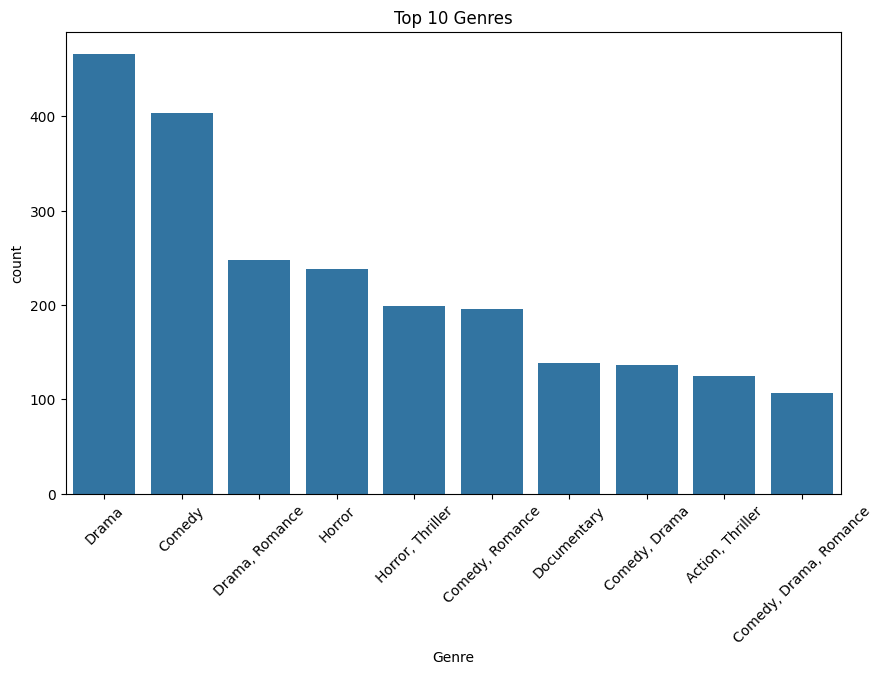

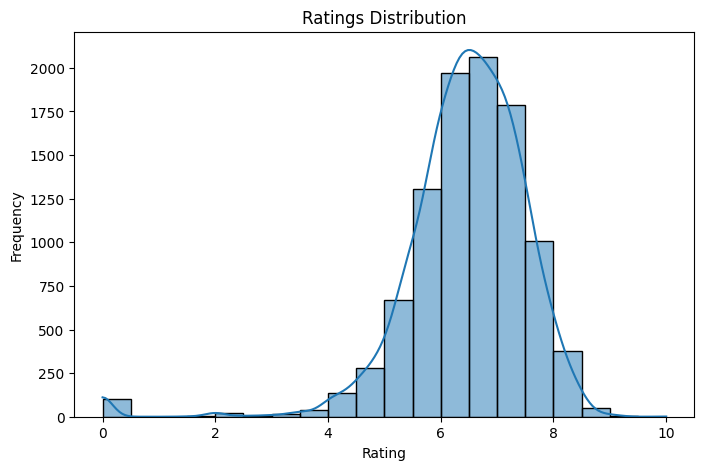

In [9]:
# Top 10 genres
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='Genre', order=df['Genre'].value_counts().index[:10])
plt.title("Top 10 Genres")
plt.xticks(rotation=45)
plt.show()

# Distribution of ratings
plt.figure(figsize=(8, 5))
sns.histplot(df['Vote_Average'], bins=20, kde=True)
plt.title("Ratings Distribution")
plt.xlabel("Rating")
plt.ylabel("Frequency")
plt.show()


In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

# Preprocess genres and overview
df['Genre'] = df['Genre'].str.split(', ')  # Split genre into list

# Vectorizing 'Genre' and 'Overview'
tfidf_genre = TfidfVectorizer(stop_words='english')
tfidf_matrix_genre = tfidf_genre.fit_transform(df['Genre'].apply(lambda x: ' '.join(x)))

tfidf_overview = TfidfVectorizer(stop_words='english')
tfidf_matrix_overview = tfidf_overview.fit_transform(df['Overview'])

# Compute cosine similarity
cosine_sim_genre = linear_kernel(tfidf_matrix_genre, tfidf_matrix_genre)
cosine_sim_overview = linear_kernel(tfidf_matrix_overview, tfidf_matrix_overview)

# Combine both similarities (weighted average)
combined_cosine_sim = (cosine_sim_genre + cosine_sim_overview) / 2

# Create a mapping of movie titles to indices
movie_indices = pd.Series(df.index, index=df['Title']).drop_duplicates()

# Function to get recommendations based on genre and overview similarity
def get_recommendations(title, cosine_sim=combined_cosine_sim):
    idx = movie_indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)[1:11]  # Top 10 recommendations
    movie_indices_recommended = [i[0] for i in sim_scores]
    return df['Title'].iloc[movie_indices_recommended]

# Example usage
print(get_recommendations("Spider-Man: No Way Home"))


144               Spider-Man: Far From Home
168                  Spider-Man: Homecoming
3583         Transformers: Dark of the Moon
685                                 Ant-Man
191       Spider-Man: Into the Spider-Verse
23                 The Matrix Resurrections
2276    Transformers: Revenge of the Fallen
499          Guardians of the Galaxy Vol. 2
635                      Mad Max: Fury Road
1223                Guardians of the Galaxy
Name: Title, dtype: object


C:\Users\HP\AppData\Local\Temp\ipykernel_12404\3472445508.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Vote_Count', y='Title', data=top_movies_by_votes, palette='viridis')


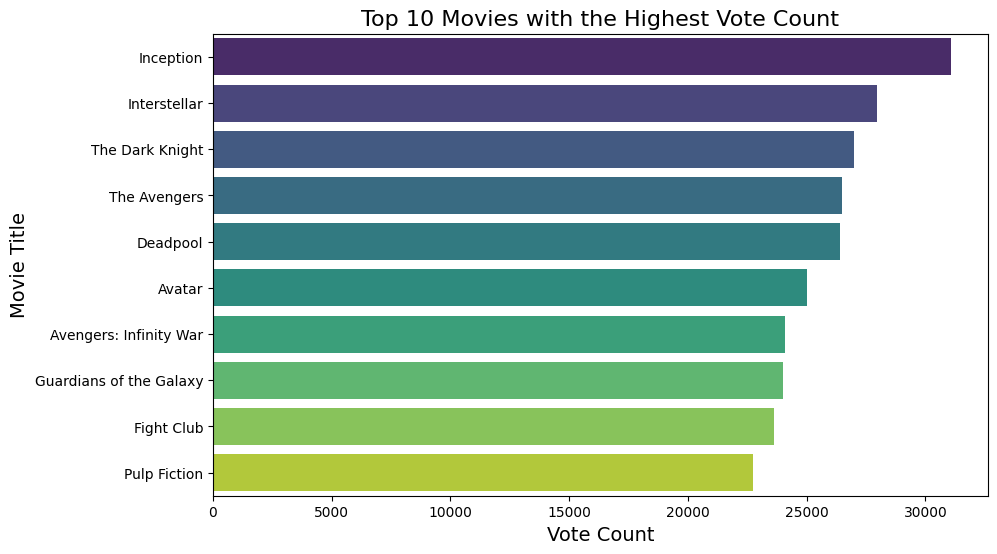

In [19]:
# Importing necessary libraries for visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Sorting the movies by 'Vote_Count' to get the top movies
top_movies_by_votes = df.sort_values(by='Vote_Count', ascending=False).head(10)

# Plotting the top movies with the highest vote count
plt.figure(figsize=(10, 6))
sns.barplot(x='Vote_Count', y='Title', data=top_movies_by_votes, palette='viridis')

# Adding labels and title
plt.title('Top 10 Movies with the Highest Vote Count', fontsize=16)
plt.xlabel('Vote Count', fontsize=14)
plt.ylabel('Movie Title', fontsize=14)
plt.show()


In [11]:
# Create a pivot table for collaborative filtering
ratings_matrix = df.pivot_table(index='Title', columns='Vote_Count', values='Vote_Average').fillna(0)

# Apply SVD for dimensionality reduction
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=20, random_state=42)  # n_components can be adjusted
matrix_svd = svd.fit_transform(ratings_matrix)

# Compute similarity between movies
similarity = np.corrcoef(matrix_svd)

# Function to recommend based on collaborative filtering
def recommend_movie(title):
    movie_idx = df[df['Title'] == title].index[0]
    similarity_scores = similarity[movie_idx]
    similar_movies = sorted(list(enumerate(similarity_scores)), key=lambda x: x[1], reverse=True)[1:11]  # Top 10
    recommended_titles = [df['Title'].iloc[i[0]] for i in similar_movies]
    return recommended_titles

# Example usage
print(recommend_movie("The Batman"))


c:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\lib\_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\lib\_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


['Uncharted: Live Action Fan Film', 'Twister', 'Superbad', 'Mickey and Minnie Wish Upon a Christmas', 'Iron Man 3', 'Rogue Hostage', 'Doctor Strange', 'The Last Duel', 'Wonder Woman 1984', 'Tentacles']


In [12]:
# Ensure that the ratings matrix has no NaN values (if any)
ratings_matrix = ratings_matrix.fillna(0)

# Normalize the ratings matrix to remove user bias
normalized_matrix = ratings_matrix - ratings_matrix.mean(axis=1).values.reshape(-1, 1)

# Normalize columns to avoid division by zero
normalized_matrix = normalized_matrix / (normalized_matrix.std(axis=1, ddof=0).values.reshape(-1, 1) + 1e-10)  # Adding small epsilon to avoid division by zero


In [13]:
# Ensure no missing values in the similarity calculation
from sklearn.metrics.pairwise import cosine_similarity

# Compute the cosine similarity for the normalized ratings matrix
cosine_sim = cosine_similarity(normalized_matrix)

# Fix any potential issues with zero ratings by replacing those values with 0
cosine_sim[np.isnan(cosine_sim)] = 0  # Handle NaNs in cosine similarity matrix


In [15]:
# Filter movies with sufficient ratings and votes
min_votes = 500  # Minimum number of votes
min_rating = 6.0  # Minimum rating average

# Filter movies with vote count and rating conditions
filtered_movies = df[(df['Vote_Count'] > min_votes) & (df['Vote_Average'] >= min_rating)]

# Get recommendations based on the filtered movies
def get_filtered_recommendations(title, cosine_sim=cosine_sim):
    idx = movie_indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)[1:11]  # Top 10 recommendations
    movie_indices_recommended = [i[0] for i in sim_scores]
    
    # Filter the recommendations to ensure they meet the vote and rating criteria
    recommended_titles = filtered_movies['Title'].iloc[movie_indices_recommended]
    
    return recommended_titles

# Example usage
print(get_filtered_recommendations("Spider-Man: No Way Home"))


5936                                The Skeleton Key
306     Harry Potter and the Deathly Hallows: Part 1
424                                  The Incredibles
679                             The Power of the Dog
698                            Terminator: Dark Fate
846                                        Peter Pan
935                                 Django Unchained
1187             Barbie in The 12 Dancing Princesses
1215                            I Spit on Your Grave
1232                                      Shark Tale
Name: Title, dtype: object
